In [49]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [50]:
# Setting up data fetching
yf.pdr_override() 
ticker = 'PG'
begin = '2010-01-01'
df = yf.download(ticker, start=begin)

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

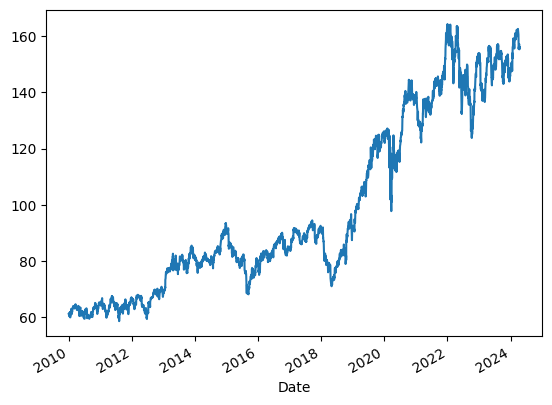

In [51]:
close = df['Close']
close.plot()

In [52]:
# Preparing dataset
ds = df['Close'].values.reshape(-1,1)

In [53]:
# Normalizing data
scaler = MinMaxScaler(feature_range=(0,1))
ds_scaled = scaler.fit_transform(ds)

In [56]:
# Splitting dataset into train and test
train_size = int(len(ds_scaled) * 0.70)
test_size = len(ds_scaled) - train_size
ds_train, ds_test = ds_scaled[0:train_size, :], ds_scaled[train_size:len(ds_scaled), :]

In [57]:
# Function to create dataset in time series format for LSTM model
def create_dataset(dataset, time_step=100):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [58]:
# Preparing train and test data
time_step = 100
X_train, y_train = create_dataset(ds_train, time_step)
X_test, y_test = create_dataset(ds_test, time_step)

In [59]:
# Reshaping input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [61]:
# Creating LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [62]:
# Training the model
model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/30
38/38 [==============================] - 10s 168ms/step - loss: 0.0048 - val_loss: 0.0027
Epoch 2/30
38/38 [==============================] - 5s 141ms/step - loss: 3.8870e-04 - val_loss: 0.0019
Epoch 3/30
38/38 [==============================] - 5s 141ms/step - loss: 3.5042e-04 - val_loss: 0.0016
Epoch 4/30
38/38 [==============================] - 5s 139ms/step - loss: 3.2859e-04 - val_loss: 0.0015
Epoch 5/30
38/38 [==============================] - 5s 138ms/step - loss: 3.1586e-04 - val_loss: 0.0016
Epoch 6/30
38/38 [==============================] - 5s 138ms/step - loss: 3.2359e-04 - val_loss: 0.0018
Epoch 7/30
38/38 [==============================] - 5s 139ms/step - loss: 3.0069e-04 - val_loss: 0.0011
Epoch 8/30
38/38 [==============================] - 5s 139ms/step - loss: 2.7465e-04 - val_loss: 0.0011
Epoch 9/30
38/38 [==============================] - 5s 139ms/step - loss: 2.6361e-04 - val_loss: 0.0010
Epoch 10/30
38/38 [==============================] - 5s 139ms/step 

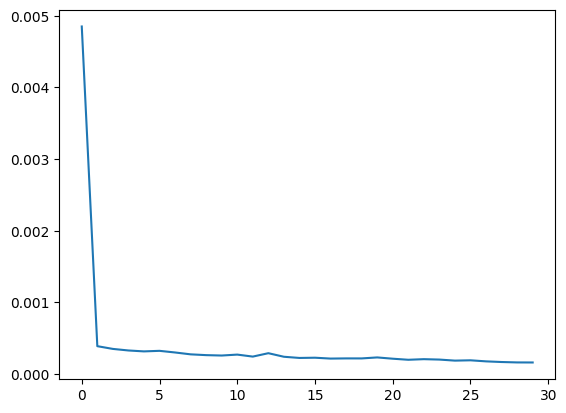

In [63]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss, label='Loss')

In [64]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

31/31 [==============================] - 1s 28ms/step


In [65]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

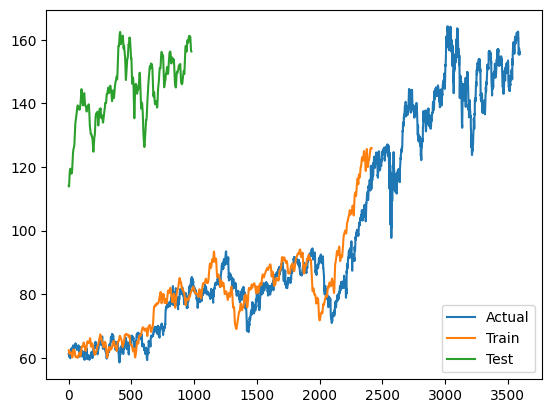

In [66]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled), label="Actual")
plt.plot(train_predict, label="Train")
plt.plot(test_predict, label="Test")
plt.legend()

In [67]:
test = np.vstack((train_predict,test_predict))

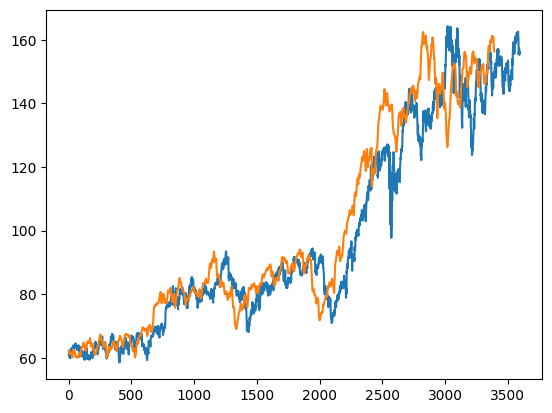

In [68]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test, label='Test')

In [69]:
#Getting the last 100 days records
fut_inp = ds_test[978:]
print(len(fut_inp))

101


In [70]:
fut_inp = fut_inp.reshape(1,-1)
tmp_inp = list(fut_inp)

#Creating list of the last 728 data
tmp_inp = tmp_inp[0].tolist()

In [71]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
print(lst_output)

print(len(ds_scaled))

[[0.9243800640106201], [0.9248822927474976], [0.9258118867874146], [0.9269206523895264], [0.9280413389205933], [0.9290765523910522], [0.9299755096435547], [0.9307172298431396], [0.9312976598739624], [0.9317246675491333], [0.9320114850997925], [0.9321763515472412], [0.9322385787963867], [0.9322191476821899], [0.9321383237838745], [0.9320147037506104], [0.9318653345108032], [0.9317047595977783], [0.9315450191497803], [0.9313952922821045], [0.9312620162963867], [0.9311500787734985], [0.9310617446899414], [0.9309971332550049], [0.9309560060501099], [0.930936336517334], [0.9309355020523071], [0.9309505224227905], [0.930978536605835], [0.9310158491134644]]
3595


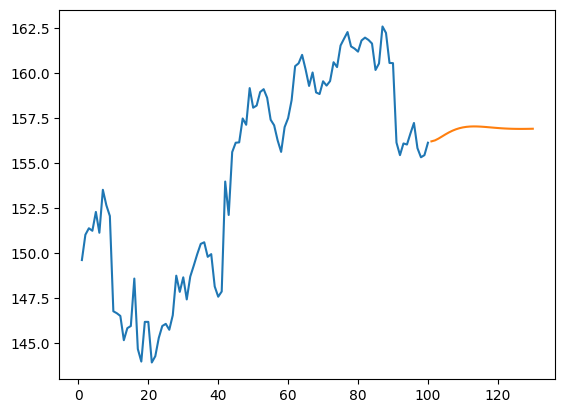

In [72]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[3495:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

3625


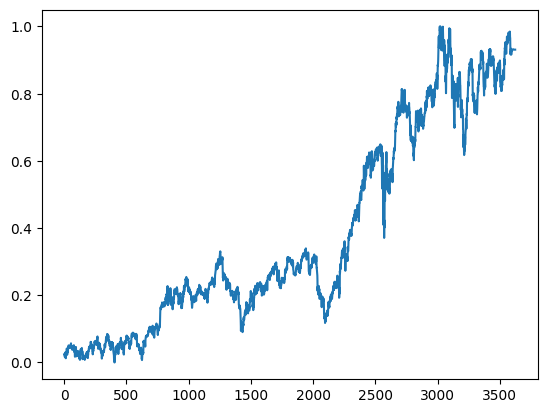

In [73]:
ds_new = ds_scaled.tolist()
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new)
print(len(ds_new))

In [74]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

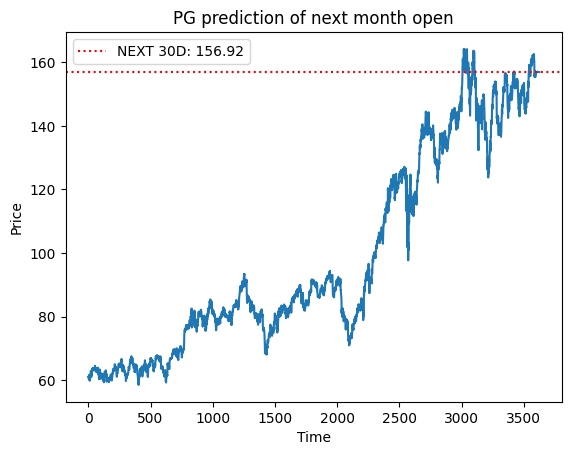

In [75]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(ticker))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()